In [536]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,BatchNormalization
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Recupération des données

In [537]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [538]:
print("Dimension of x_train",x_train.shape)
print("Dimension of x_test",x_test.shape)
print("Dimension of y_test",y_test.shape)

Dimension of x_train (60000, 28, 28)
Dimension of x_test (10000, 28, 28)
Dimension of y_test (10000,)


label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64


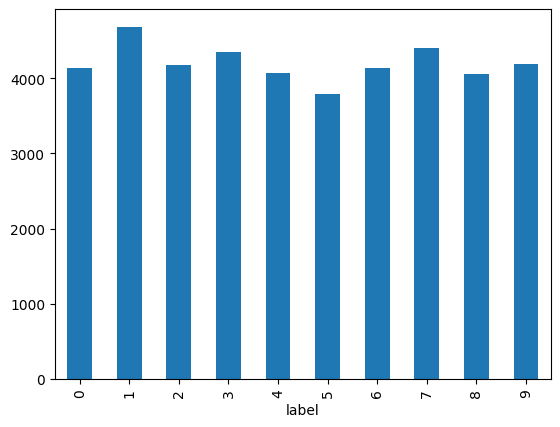

In [539]:
train_data['label'].value_counts().sort_index().plot(kind='bar')
print(train_data['label'].value_counts())

# Questions guidées 

## 1-a)

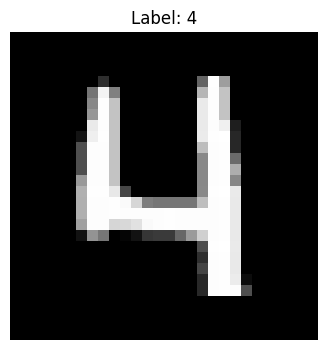

In [540]:
random_index = np.random.randint(0, len(train_data))
random_row = train_data.iloc[random_index, :]

label = random_row['label']
pixels = random_row.drop('label')

image = pixels.values.reshape(28, 28)

plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.title('Label: %s' % label)
plt.axis('off')
plt.show()

## 1-b)

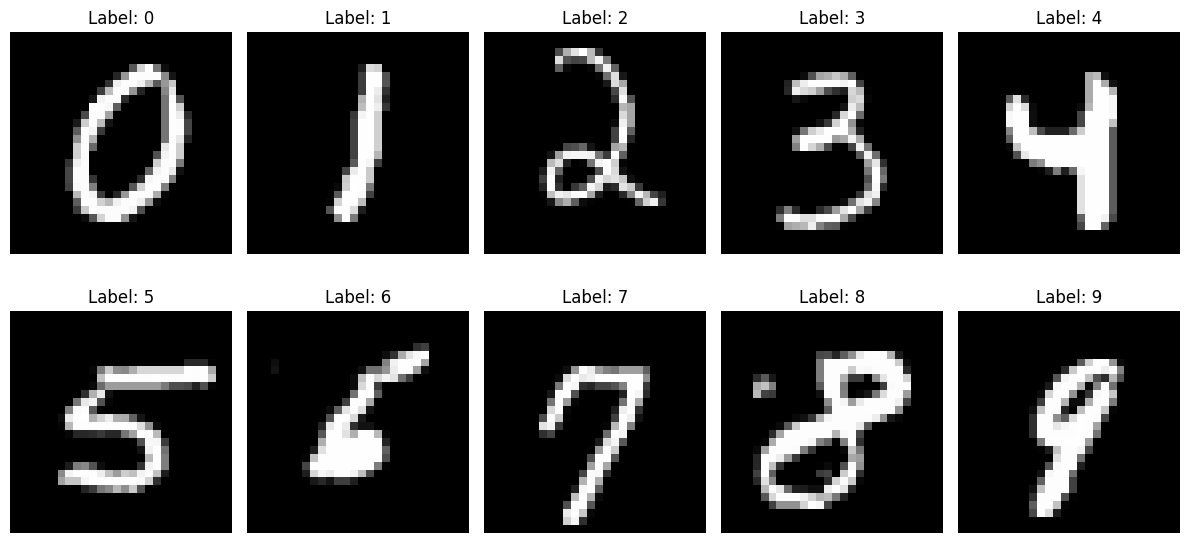

In [541]:
label_images = {}

for label in range(10):
  
  label_df = train_data[train_data['label'] == label]

  random_index = np.random.randint(0, len(label_df))
  random_row = label_df.iloc[random_index, :]

  pixels = random_row.drop('label')
  image = pixels.values.reshape(28, 28)

  label_images[label] = image

plt.figure(figsize=(12, 6))
for label, image in label_images.items():
  plt.subplot(2, 5, label + 1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Label: {label}')
  plt.axis('off')

plt.tight_layout()
plt.show()

## 1-c)

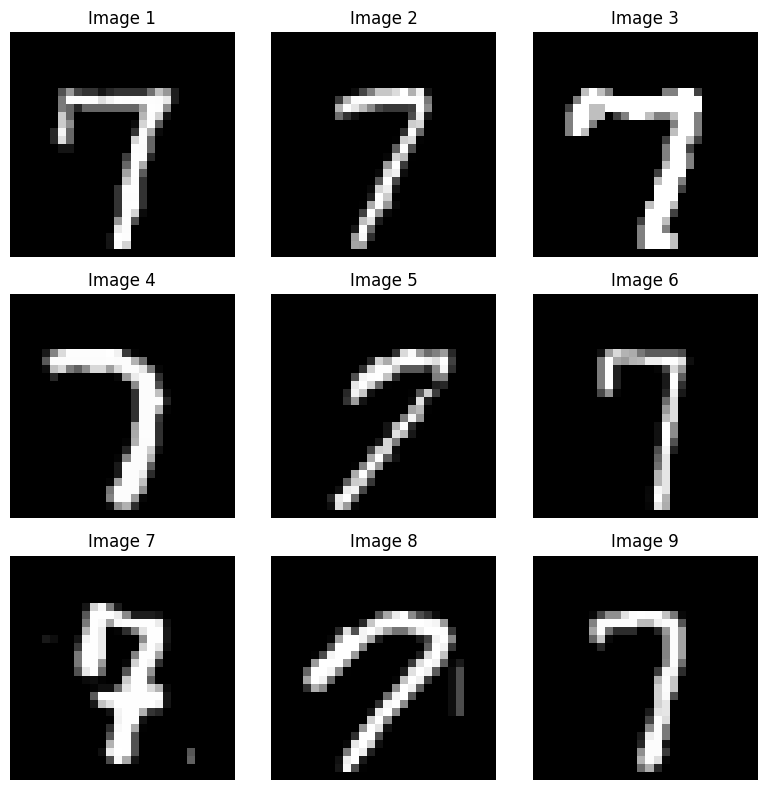

In [542]:
label_7_df = train_data[train_data['label'] == 7].head(9)

images = []

for index, row in label_7_df.iterrows():
  pixels = row.drop('label')
  image = pixels.values.reshape(28, 28)
  images.append(image)

plt.figure(figsize=(8, 8))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(images[i], cmap='gray')
  plt.title(f'Image {i + 1}')
  plt.axis('off')

plt.tight_layout()
plt.show()

## 1-d)

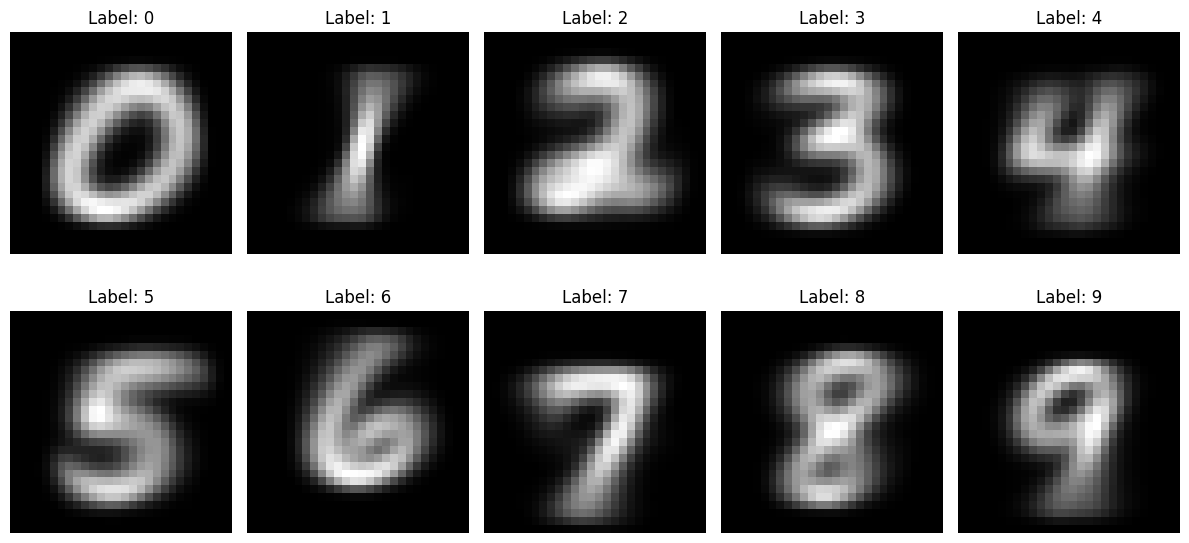

In [543]:
label_average_images = {}

for label in range(10):
  label_df = train_data[train_data['label'] == label]

  mean_pixels = label_df.drop('label', axis=1).mean().values

  mean_image = mean_pixels.reshape(28, 28)

  label_average_images[label] = mean_image

plt.figure(figsize=(12, 6))
for label, image in label_average_images.items():
  plt.subplot(2, 5, label + 1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Label: {label}')
  plt.axis('off')

plt.tight_layout()
plt.show()

# Définition et entraînement du modèle

## Paramêtres du modèle

In [544]:
num_classes = 10
epochs = 30
batch_size = 128
img_rows = 28 
img_cols = 28

In [545]:
x_train =x_train.astype(float)
x_train =x_train/255
x_test =x_test.astype(float)
x_test =x_test/255
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 10, dtype = 'float32')
y_test = to_categorical(y_test, num_classes = 10, dtype = 'float32')

In [546]:
if K.image_data_format() =='channels_first':
    x_train = x_train.reshape(x_train.shape[0],1,img_rows,img_cols)
    x_test = x_test.reshape(x_test.shape[0],1,img_rows,img_cols)
    input_shape = (1,img_rows,img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
    x_test = x_test.reshape(x_test.shape[0],img_rows,img_cols,1)
    input_shape = (img_rows,img_cols,1)

In [547]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [548]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [549]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_159 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_160 (Conv2D)         (None, 11, 11, 32)        9248      
                                                                 
 batch_normalization_135 (Ba  (None, 11, 11, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_161 (Conv2D)         (None, 6, 6, 32)          25632     
                                                                 
 batch_normalization_136 (Ba  (None, 6, 6, 32)       

## Entraînement du modèle

In [550]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test,y_test))

Epoch 1/30


2023-09-20 11:35:35.044455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_27/dropout_81/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 8s 9ms/step - loss: 0.4084 - accuracy: 0.8799 - val_loss: 0.0960 - val_accuracy: 0.9718
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1088 - accuracy: 0.9700 - val_loss: 0.0528 - val_accuracy: 0.9839
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0771 - accuracy: 0.9790 - val_loss: 0.0335 - val_accuracy: 0.9894
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0603 - accuracy: 0.9840 - val_loss: 0.0383 - val_accuracy: 0.9870
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0479 - accuracy: 0.9869 - val_loss: 0.0261 - val_accuracy: 0.9925
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0468 - accuracy: 0.9866 - val_loss: 0.0342 - val_accuracy: 0.9915
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0421 - accuracy: 0.9884 - val_loss: 0.0272 - val_accuracy: 0.9927
Epoch 8/30
469/46

## Evaluation du modèle

In [553]:
score ,acc = model.evaluate(x_test,y_test)
print("Score is :",score)
print("Accuracy :",acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.0265 - accuracy: 0.9945
Score is : 0.02652631886303425
Accuracy : 0.9944999814033508


313/313 [==============================] - 1s 2ms/step


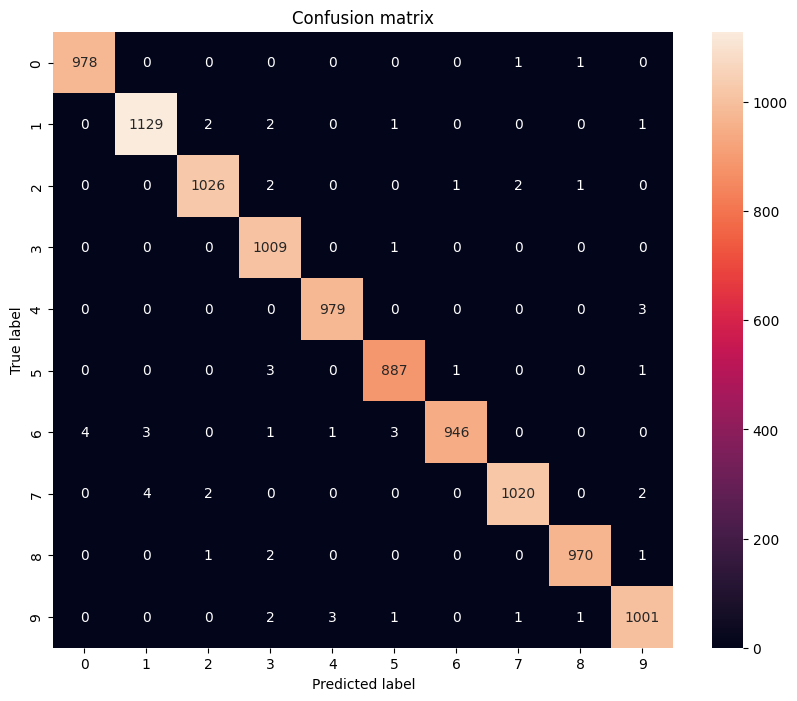

In [555]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

# Enregistrement du modèle au format H5

In [ ]:
model.save("modelH5.h5")

# Questions suite

## 7-

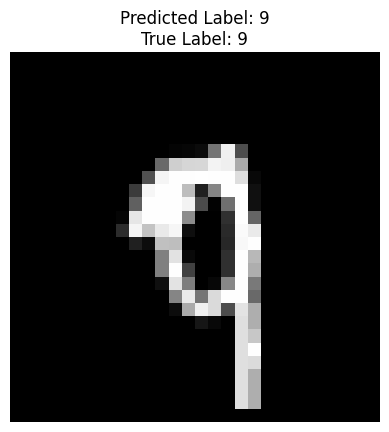

In [557]:
correct_index = np.where(y_pred_classes == y_true)[0]
index = np.random.choice(correct_index)
plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted Label: {y_pred_classes[index]}\nTrue Label: {y_true[index]}")
plt.axis('off')
plt.show()

## 8-

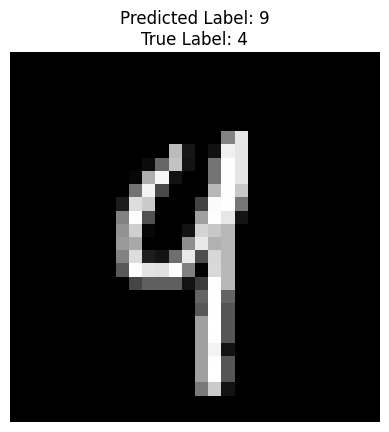

In [558]:
incorrect_index = np.where(y_pred_classes != y_true)[0]
index = np.random.choice(incorrect_index)
plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted Label: {y_pred_classes[index]}\nTrue Label: {y_true[index]}")
plt.axis('off')
plt.show()